<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_stride2_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from cifar10_dataset import Cifar10Dataset
from train import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
from model_stride2 import Net

# Check if GPU available

In [ ]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [ ]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 79686232.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


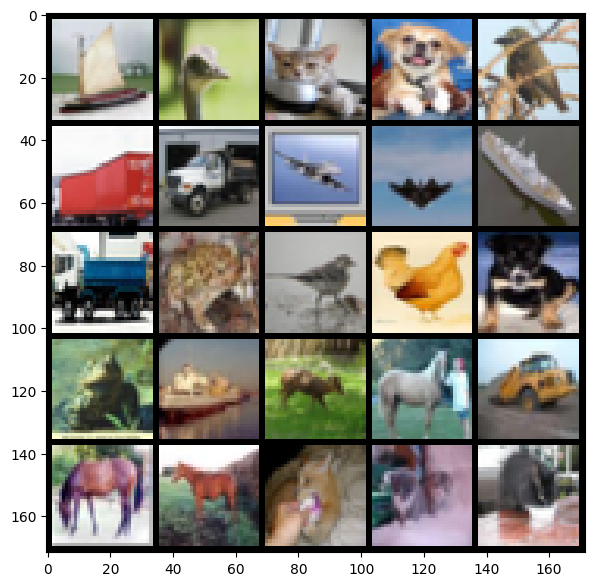

In [ ]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [ ]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


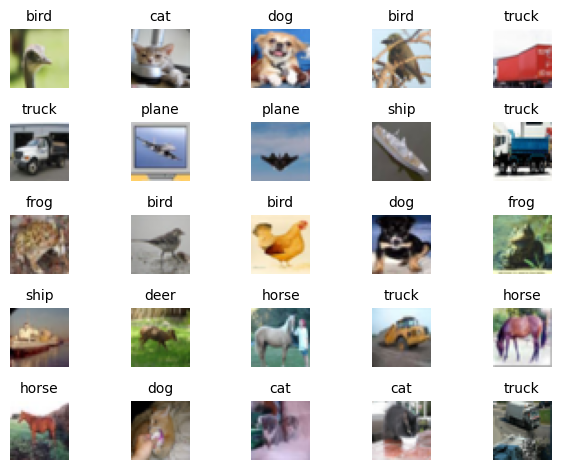

In [ ]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [ ]:
# Train Phase transformations
train_transforms = A.Compose([
                                # A.RandomResizedCrop(p=0.5, height=32, width=32),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(p=0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                #                 fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=0.5),
                                A.Compose([A.PadIfNeeded (min_height=64, min_width=64, p = 1.0),
                                            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=1),
                                           A.CenterCrop(height=32, width=32, p=1),
                                ], p = 1),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [ ]:
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
               CoarseDropout(always_apply=False, p=1, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], m

# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


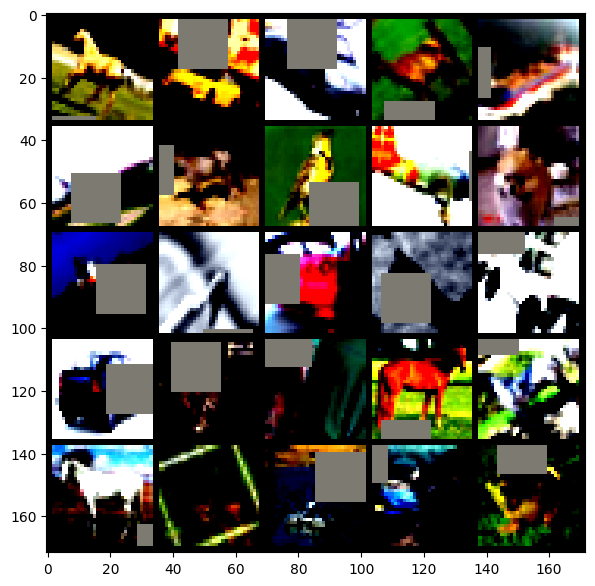

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [ ]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
current_learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=current_learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 3,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 10
best_test_loss = np.inf
best_epoch = -1

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    if current_learning_rate != scheduler.get_last_lr()[0]:
        current_learning_rate = scheduler.get_last_lr()[0]
        print(f'Learning rate updated to: {current_learning_rate}')

    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.6844 Batch_id=390 Accuracy=31.61: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]


Test set: Average loss: 1.5438, Accuracy: 4338/10000 (43.38%)

Epoch 2


Train: Loss=1.6940 Batch_id=390 Accuracy=40.05: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]


Test set: Average loss: 1.4253, Accuracy: 4785/10000 (47.85%)

Epoch 3


Train: Loss=1.4708 Batch_id=390 Accuracy=44.39: 100%|██████████| 391/391 [00:18<00:00, 20.79it/s]


Test set: Average loss: 1.2805, Accuracy: 5330/10000 (53.30%)

Epoch 4


Train: Loss=1.4781 Batch_id=390 Accuracy=47.91: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s]


Test set: Average loss: 1.1897, Accuracy: 5696/10000 (56.96%)

Epoch 5


Train: Loss=1.3717 Batch_id=390 Accuracy=50.41: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]


Test set: Average loss: 1.1776, Accuracy: 5801/10000 (58.01%)

Epoch 6


Train: Loss=1.3678 Batch_id=390 Accuracy=52.73: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]


Test set: Average loss: 1.0696, Accuracy: 6184/10000 (61.84%)

Epoch 7


Train: Loss=1.1341 Batch_id=390 Accuracy=55.53: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]


Test set: Average loss: 1.0248, Accuracy: 6368/10000 (63.68%)

Epoch 8


Train: Loss=1.3041 Batch_id=390 Accuracy=57.44: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]


Test set: Average loss: 0.9140, Accuracy: 6758/10000 (67.58%)

Epoch 9


Train: Loss=1.2807 Batch_id=390 Accuracy=59.25: 100%|██████████| 391/391 [00:19<00:00, 19.72it/s]


Test set: Average loss: 0.9057, Accuracy: 6758/10000 (67.58%)

Epoch 10


Train: Loss=1.0816 Batch_id=390 Accuracy=60.40: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]


Test set: Average loss: 0.8380, Accuracy: 7083/10000 (70.83%)

Epoch 11


Train: Loss=0.9326 Batch_id=390 Accuracy=61.62: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.8709, Accuracy: 6949/10000 (69.49%)

Epoch 12


Train: Loss=0.9289 Batch_id=390 Accuracy=62.70: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]


Test set: Average loss: 0.8159, Accuracy: 7180/10000 (71.80%)

Epoch 13


Train: Loss=1.0705 Batch_id=390 Accuracy=63.46: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]


Test set: Average loss: 0.7979, Accuracy: 7216/10000 (72.16%)

Epoch 14


Train: Loss=0.9269 Batch_id=390 Accuracy=64.35: 100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


Test set: Average loss: 0.7716, Accuracy: 7299/10000 (72.99%)

Epoch 15


Train: Loss=0.8891 Batch_id=390 Accuracy=65.17: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


Test set: Average loss: 0.7333, Accuracy: 7494/10000 (74.94%)

Epoch 16


Train: Loss=1.0849 Batch_id=390 Accuracy=65.98: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]


Test set: Average loss: 0.7425, Accuracy: 7397/10000 (73.97%)

Epoch 17


Train: Loss=1.0023 Batch_id=390 Accuracy=66.63: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]


Test set: Average loss: 0.6994, Accuracy: 7565/10000 (75.65%)

Epoch 18


Train: Loss=1.1403 Batch_id=390 Accuracy=67.34: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]


Test set: Average loss: 0.6880, Accuracy: 7625/10000 (76.25%)

Epoch 19


Train: Loss=1.0247 Batch_id=390 Accuracy=67.75: 100%|██████████| 391/391 [00:20<00:00, 19.39it/s]


Test set: Average loss: 0.6723, Accuracy: 7688/10000 (76.88%)

Epoch 20


Train: Loss=0.8534 Batch_id=390 Accuracy=68.35: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]


Test set: Average loss: 0.6754, Accuracy: 7703/10000 (77.03%)

Epoch 21


Train: Loss=0.8335 Batch_id=390 Accuracy=68.40: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Test set: Average loss: 0.6662, Accuracy: 7675/10000 (76.75%)

Epoch 22


Train: Loss=0.8659 Batch_id=390 Accuracy=69.04: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]


Test set: Average loss: 0.6473, Accuracy: 7736/10000 (77.36%)

Epoch 23


Train: Loss=0.9724 Batch_id=390 Accuracy=69.31: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]


Test set: Average loss: 0.6546, Accuracy: 7754/10000 (77.54%)

Epoch 24


Train: Loss=0.8044 Batch_id=390 Accuracy=69.92: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]


Test set: Average loss: 0.6377, Accuracy: 7848/10000 (78.48%)

Epoch 25


Train: Loss=0.7017 Batch_id=390 Accuracy=70.42: 100%|██████████| 391/391 [00:19<00:00, 20.51it/s]


Test set: Average loss: 0.6169, Accuracy: 7869/10000 (78.69%)

Epoch 26


Train: Loss=0.8889 Batch_id=390 Accuracy=70.36: 100%|██████████| 391/391 [00:20<00:00, 19.40it/s]


Test set: Average loss: 0.6157, Accuracy: 7869/10000 (78.69%)

Epoch 27


Train: Loss=0.9211 Batch_id=390 Accuracy=70.71: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]


Test set: Average loss: 0.6016, Accuracy: 7943/10000 (79.43%)

Epoch 28


Train: Loss=0.8982 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]


Test set: Average loss: 0.5911, Accuracy: 7980/10000 (79.80%)

Epoch 29


Train: Loss=0.8116 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]


Test set: Average loss: 0.5643, Accuracy: 8072/10000 (80.72%)

Epoch 30


Train: Loss=0.9231 Batch_id=390 Accuracy=72.05: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]


Test set: Average loss: 0.5873, Accuracy: 7981/10000 (79.81%)

Epoch 31


Train: Loss=0.9223 Batch_id=390 Accuracy=71.86: 100%|██████████| 391/391 [00:20<00:00, 18.99it/s]


Test set: Average loss: 0.5881, Accuracy: 8009/10000 (80.09%)

Epoch 32


Train: Loss=0.6992 Batch_id=390 Accuracy=72.46: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]


Test set: Average loss: 0.5747, Accuracy: 8049/10000 (80.49%)

Epoch 33


Train: Loss=0.5182 Batch_id=390 Accuracy=72.75: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]


Test set: Average loss: 0.5502, Accuracy: 8113/10000 (81.13%)

Epoch 34


Train: Loss=0.7607 Batch_id=390 Accuracy=72.70: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]


Test set: Average loss: 0.5754, Accuracy: 8037/10000 (80.37%)

Epoch 35


Train: Loss=0.9242 Batch_id=390 Accuracy=73.01: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]


Test set: Average loss: 0.5736, Accuracy: 8065/10000 (80.65%)

Epoch 36


Train: Loss=0.7192 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]


Test set: Average loss: 0.5472, Accuracy: 8114/10000 (81.14%)

Epoch 37


Train: Loss=1.1403 Batch_id=390 Accuracy=73.51: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]


Test set: Average loss: 0.5571, Accuracy: 8102/10000 (81.02%)

Epoch 38


Train: Loss=0.5696 Batch_id=390 Accuracy=73.90: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]


Test set: Average loss: 0.5382, Accuracy: 8190/10000 (81.90%)

Epoch 39


Train: Loss=0.6708 Batch_id=390 Accuracy=73.80: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


Test set: Average loss: 0.5497, Accuracy: 8138/10000 (81.38%)

Epoch 40


Train: Loss=0.7533 Batch_id=390 Accuracy=73.99: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]


Test set: Average loss: 0.5376, Accuracy: 8180/10000 (81.80%)

Epoch 41


Train: Loss=0.5814 Batch_id=390 Accuracy=74.20: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]


Test set: Average loss: 0.5383, Accuracy: 8203/10000 (82.03%)

Epoch 42


Train: Loss=0.8473 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:19<00:00, 19.88it/s]


Test set: Average loss: 0.5173, Accuracy: 8230/10000 (82.30%)

Epoch 43


Train: Loss=0.7626 Batch_id=390 Accuracy=74.56: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]


Test set: Average loss: 0.4993, Accuracy: 8273/10000 (82.73%)

Epoch 44


Train: Loss=0.6981 Batch_id=390 Accuracy=74.90: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.5114, Accuracy: 8256/10000 (82.56%)

Epoch 45


Train: Loss=0.8061 Batch_id=390 Accuracy=74.95: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]


Test set: Average loss: 0.4992, Accuracy: 8297/10000 (82.97%)

Epoch 46


Train: Loss=0.7430 Batch_id=390 Accuracy=75.23: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]


Test set: Average loss: 0.5006, Accuracy: 8310/10000 (83.10%)

Epoch 47


Train: Loss=0.7533 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]


Test set: Average loss: 0.5127, Accuracy: 8249/10000 (82.49%)

Epoch 48


Train: Loss=0.6176 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s]


Test set: Average loss: 0.4955, Accuracy: 8310/10000 (83.10%)

Epoch 49


Train: Loss=0.6023 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]


Test set: Average loss: 0.5093, Accuracy: 8274/10000 (82.74%)

Epoch 50


Train: Loss=0.5886 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


Test set: Average loss: 0.4822, Accuracy: 8373/10000 (83.73%)

Epoch 51


Train: Loss=0.8280 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Test set: Average loss: 0.5066, Accuracy: 8287/10000 (82.87%)

Epoch 52


Train: Loss=0.8778 Batch_id=390 Accuracy=76.20: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


Test set: Average loss: 0.4906, Accuracy: 8341/10000 (83.41%)

Epoch 53


Train: Loss=0.6435 Batch_id=390 Accuracy=76.26: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s]


Test set: Average loss: 0.4656, Accuracy: 8400/10000 (84.00%)

Epoch 54


Train: Loss=0.4580 Batch_id=390 Accuracy=76.21: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]


Test set: Average loss: 0.4712, Accuracy: 8421/10000 (84.21%)

Epoch 55


Train: Loss=0.5170 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]


Test set: Average loss: 0.4586, Accuracy: 8416/10000 (84.16%)

Epoch 56


Train: Loss=0.7835 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]


Test set: Average loss: 0.4670, Accuracy: 8390/10000 (83.90%)

Epoch 57


Train: Loss=0.7117 Batch_id=390 Accuracy=76.35: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]


Test set: Average loss: 0.4786, Accuracy: 8373/10000 (83.73%)

Epoch 58


Train: Loss=0.7692 Batch_id=390 Accuracy=76.81: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]


Test set: Average loss: 0.4638, Accuracy: 8434/10000 (84.34%)

Epoch 59


Train: Loss=0.6978 Batch_id=390 Accuracy=76.75: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]


Test set: Average loss: 0.4444, Accuracy: 8438/10000 (84.38%)

Epoch 60


Train: Loss=0.6769 Batch_id=390 Accuracy=76.87: 100%|██████████| 391/391 [00:19<00:00, 19.75it/s]


Test set: Average loss: 0.4399, Accuracy: 8504/10000 (85.04%)

Epoch 61


Train: Loss=0.6965 Batch_id=390 Accuracy=76.98: 100%|██████████| 391/391 [00:18<00:00, 20.83it/s]


Test set: Average loss: 0.4543, Accuracy: 8445/10000 (84.45%)

Epoch 62


Train: Loss=0.5092 Batch_id=390 Accuracy=77.11: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]


Test set: Average loss: 0.4550, Accuracy: 8424/10000 (84.24%)

Epoch 63


Train: Loss=0.6163 Batch_id=390 Accuracy=77.18: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]


Test set: Average loss: 0.4487, Accuracy: 8462/10000 (84.62%)

Epoch 64


Train: Loss=0.6764 Batch_id=390 Accuracy=77.53: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]


Test set: Average loss: 0.4476, Accuracy: 8478/10000 (84.78%)

Learning rate updated to: 0.010000000000000002
Epoch 65


Train: Loss=0.6716 Batch_id=390 Accuracy=78.81: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]


Test set: Average loss: 0.4134, Accuracy: 8593/10000 (85.93%)

Epoch 66


Train: Loss=0.5555 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


Test set: Average loss: 0.4072, Accuracy: 8624/10000 (86.24%)

Epoch 67


Train: Loss=0.5293 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:20<00:00, 19.45it/s]


Test set: Average loss: 0.4015, Accuracy: 8622/10000 (86.22%)

Epoch 68


Train: Loss=0.7511 Batch_id=390 Accuracy=79.68: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]


Test set: Average loss: 0.3966, Accuracy: 8645/10000 (86.45%)

Epoch 69


Train: Loss=0.5479 Batch_id=390 Accuracy=79.74: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]


Test set: Average loss: 0.3981, Accuracy: 8654/10000 (86.54%)

Epoch 70


Train: Loss=0.6280 Batch_id=390 Accuracy=79.57: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]


Test set: Average loss: 0.3971, Accuracy: 8655/10000 (86.55%)

Epoch 71


Train: Loss=0.6648 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]


Test set: Average loss: 0.3961, Accuracy: 8640/10000 (86.40%)

Epoch 72


Train: Loss=0.6419 Batch_id=390 Accuracy=79.50: 100%|██████████| 391/391 [00:21<00:00, 18.50it/s]


Test set: Average loss: 0.3966, Accuracy: 8672/10000 (86.72%)

Epoch 73


Train: Loss=0.5832 Batch_id=390 Accuracy=79.74: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]


Test set: Average loss: 0.3971, Accuracy: 8668/10000 (86.68%)

Epoch 74


Train: Loss=0.5082 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:20<00:00, 19.49it/s]


Test set: Average loss: 0.3924, Accuracy: 8670/10000 (86.70%)

Epoch 75


Train: Loss=0.5556 Batch_id=390 Accuracy=80.04: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]


Test set: Average loss: 0.3948, Accuracy: 8675/10000 (86.75%)

Epoch 76


Train: Loss=0.4686 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]


Test set: Average loss: 0.3923, Accuracy: 8687/10000 (86.87%)

Epoch 77


Train: Loss=0.5331 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]


Test set: Average loss: 0.3913, Accuracy: 8700/10000 (87.00%)

Epoch 78


Train: Loss=0.5859 Batch_id=390 Accuracy=79.82: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Test set: Average loss: 0.3917, Accuracy: 8689/10000 (86.89%)

Epoch 79


Train: Loss=0.6198 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [00:19<00:00, 19.81it/s]


Test set: Average loss: 0.3945, Accuracy: 8657/10000 (86.57%)

Epoch 80


Train: Loss=0.5570 Batch_id=390 Accuracy=80.15: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]


Test set: Average loss: 0.3922, Accuracy: 8670/10000 (86.70%)

Epoch 81


Train: Loss=0.6878 Batch_id=390 Accuracy=80.05: 100%|██████████| 391/391 [00:19<00:00, 20.19it/s]


Test set: Average loss: 0.3915, Accuracy: 8669/10000 (86.69%)

Learning rate updated to: 0.0010000000000000002
Epoch 82


Train: Loss=0.5028 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


Test set: Average loss: 0.3898, Accuracy: 8676/10000 (86.76%)

Epoch 83


Train: Loss=0.4389 Batch_id=390 Accuracy=80.15: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]


Test set: Average loss: 0.3910, Accuracy: 8666/10000 (86.66%)

Epoch 84


Train: Loss=0.5676 Batch_id=390 Accuracy=80.37: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]


Test set: Average loss: 0.3896, Accuracy: 8679/10000 (86.79%)

Epoch 85


Train: Loss=0.7432 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]


Test set: Average loss: 0.3881, Accuracy: 8688/10000 (86.88%)

Epoch 86


Train: Loss=0.5003 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]


Test set: Average loss: 0.3933, Accuracy: 8661/10000 (86.61%)

Epoch 87


Train: Loss=0.5314 Batch_id=390 Accuracy=80.35: 100%|██████████| 391/391 [00:20<00:00, 19.51it/s]


Test set: Average loss: 0.3922, Accuracy: 8667/10000 (86.67%)

Epoch 88


Train: Loss=0.6623 Batch_id=390 Accuracy=80.46: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]


Test set: Average loss: 0.3903, Accuracy: 8690/10000 (86.90%)

Epoch 89


Train: Loss=0.5848 Batch_id=390 Accuracy=80.41: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]


Test set: Average loss: 0.3872, Accuracy: 8692/10000 (86.92%)

Epoch 90


Train: Loss=0.7585 Batch_id=390 Accuracy=80.16: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]


Test set: Average loss: 0.3907, Accuracy: 8684/10000 (86.84%)

Epoch 91


Train: Loss=0.4624 Batch_id=390 Accuracy=80.48: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]


Test set: Average loss: 0.3897, Accuracy: 8680/10000 (86.80%)

Epoch 92


Train: Loss=0.5503 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:19<00:00, 19.86it/s]


Test set: Average loss: 0.3876, Accuracy: 8697/10000 (86.97%)

Epoch 93


Train: Loss=0.6680 Batch_id=390 Accuracy=80.32: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]


Test set: Average loss: 0.3882, Accuracy: 8682/10000 (86.82%)

Learning rate updated to: 0.00010000000000000003
Epoch 94


Train: Loss=0.6887 Batch_id=390 Accuracy=80.37: 100%|██████████| 391/391 [00:19<00:00, 19.58it/s]


Test set: Average loss: 0.3889, Accuracy: 8684/10000 (86.84%)

Epoch 95


Train: Loss=0.5792 Batch_id=390 Accuracy=80.11: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]


Test set: Average loss: 0.3867, Accuracy: 8702/10000 (87.02%)

Epoch 96


Train: Loss=0.5134 Batch_id=390 Accuracy=80.37: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


Test set: Average loss: 0.3881, Accuracy: 8699/10000 (86.99%)

Epoch 97


Train: Loss=0.4710 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:19<00:00, 19.59it/s]


Test set: Average loss: 0.3909, Accuracy: 8680/10000 (86.80%)

Epoch 98


Train: Loss=0.4994 Batch_id=390 Accuracy=80.38: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


Test set: Average loss: 0.3873, Accuracy: 8704/10000 (87.04%)

Epoch 99


Train: Loss=0.4947 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:19<00:00, 19.70it/s]


Test set: Average loss: 0.3869, Accuracy: 8688/10000 (86.88%)

Epoch 100


Train: Loss=0.6043 Batch_id=390 Accuracy=80.23: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]


Test set: Average loss: 0.3877, Accuracy: 8710/10000 (87.10%)



In [ ]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

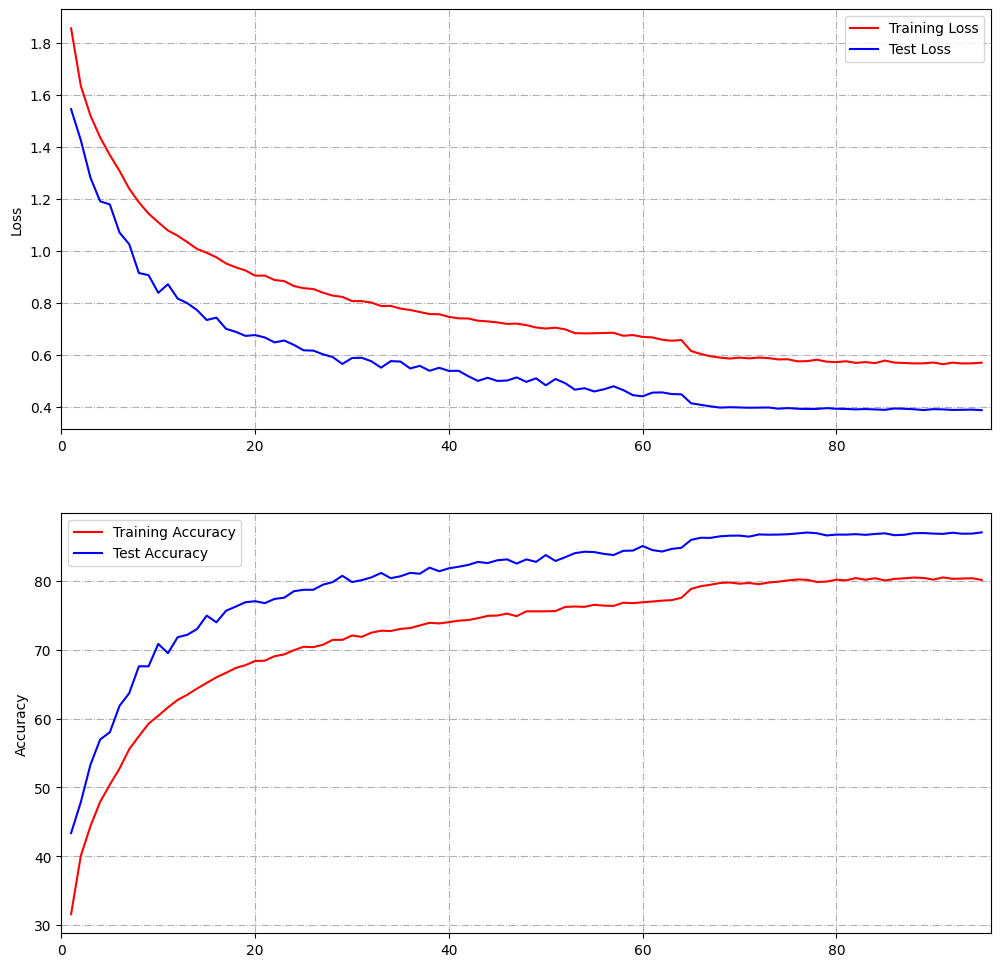

In [ ]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 1298


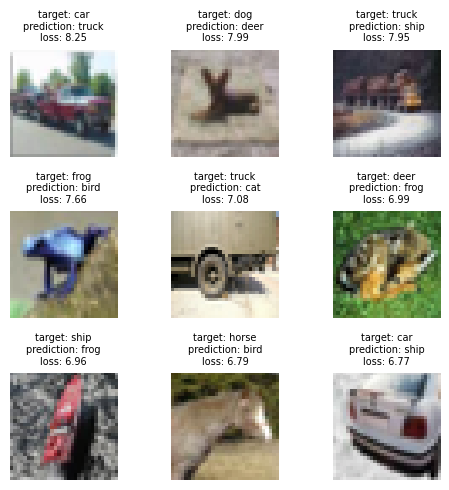

In [ ]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=3, img_cols = 3)

In [ ]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
33,dog,cat,1.531574,110
19,cat,dog,1.551577,85
2,bird,deer,1.705894,60
63,plane,ship,1.931746,48
20,cat,frog,1.716435,44
...,...,...,...,...
9,car,cat,1.670559,2
61,plane,frog,2.288462,2
47,frog,truck,4.814594,2
46,frog,ship,3.178819,2
